# Barnstable and Long-Run Risk

## HBS Case

### *The Risk of Stocks in the Long-Run: The Barnstable College Endowment*

***

# 2. Estimating Underperformance

### Data

Use the returns on the S&P 500 ($r^m$) and 1-month T-bills, ($r^f$) provided in `barnstable_analysis_data.xlsx`.
* Data goes through `END_YR=2024`.

Barnstable's estimates of mean and volatility are based on the subsample of 1965 to 1999.
* We consider this subsample, as well as 2000-{END_YR}, as well as the full sample of 1926-{END_YR}.

### Notation

* $r$ = level return rates
* $R$ = cumulative return factor
* $\texttt{r}$ = log return rates

$$ R \equiv 1+r$$

$$ \texttt{r} \equiv \ln(1+r) = \ln(R)$$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

END_YR = 2024

raw_df = pd.read_excel("../data/barnstable_analysis_data.xlsx", sheet_name="data")
raw_df.tail()

,date,SPX,TB1M
1183,2024-08-30,0.024283,0.004380
1184,2024-09-30,0.022821,0.003826
1185,2024-10-31,-0.008690,0.003752
1186,2024-11-29,0.060420,0.003475
1187,2024-12-31,-0.023445,0.003337


### 1. Summary Statistics

Report the following (annualized) statistics.

| | 1965-1999 | | | 2000-{END_YR} | | | 1926-{END_YR} | |
|---|---|---|---|---|---|---|---|---|
| | mean | vol | | mean | vol | | mean | vol |
| **levels** | $r^m$ | | | | | | | |
| | $\tilde{r}^m$ | | | | | | | |
| | $r^f$ | | | | | | | |
| **logs** | $\texttt{r}^m$ | | | | | | | |
| | $\tilde{\texttt{r}}^m$ | | | | | | | |
| | $\texttt{r}_f$ | | | | | | | |

* Comment on how the full-sample return stats compare to the sub-sample stats.
* Comment on how the level stats compare to the log stats.

In [2]:
# 1. Summary stats
# Convert date column to datetime and extract year
raw_df['date'] = pd.to_datetime(raw_df['date'])
raw_df['year'] = raw_df['date'].dt.year

# Create time period masks
mask_1965_1999 = (raw_df['year'] >= 1965) & (raw_df['year'] <= 1999)
mask_2000_end = (raw_df['year'] >= 2000) & (raw_df['year'] <= END_YR)
mask_1926_end = (raw_df['year'] >= 1926) & (raw_df['year'] <= END_YR)

# Calculate log returns
raw_df['log_SPX'] = np.log(1 + raw_df['SPX'])
raw_df['log_SPX_excess'] = np.log(1 + raw_df['SPX']) - np.log(1 + raw_df['TB1M'])
raw_df['log_TB1M'] = np.log(1 + raw_df['TB1M'])

# Function to calculate annualized statistics
def calc_stats(data, periods_per_year=12):  # Assuming monthly data
    mean_ann = data.mean() * periods_per_year
    vol_ann = data.std() * np.sqrt(periods_per_year)
    return mean_ann, vol_ann

# Calculate statistics for each period
periods = {
    '1965-1999': mask_1965_1999,
    f'2000-{END_YR}': mask_2000_end,
    f'1926-{END_YR}': mask_1926_end
}

# Initialize results dictionary
results = {}

for period_name, mask in periods.items():
    period_data = raw_df[mask]
    
    # Level returns
    SPX_mean, SPX_vol = calc_stats(period_data['SPX'])
    SPX_excess_mean, SPX_excess_vol = calc_stats(period_data['SPX'] - period_data['TB1M'])
    TB1M_mean, TB1M_vol = calc_stats(period_data['TB1M'])
    
    # Log returns
    log_SPX_mean, log_SPX_vol = calc_stats(period_data['log_SPX'])
    log_SPX_excess_mean, log_SPX_excess_vol = calc_stats(period_data['log_SPX_excess'])
    log_TB1M_mean, log_TB1M_vol = calc_stats(period_data['log_TB1M'])
    
    results[period_name] = {
        'SPX_mean': SPX_mean, 'SPX_vol': SPX_vol,
        'SPX_excess_mean': SPX_excess_mean, 'SPX_excess_vol': SPX_excess_vol,
        'TB1M_mean': TB1M_mean, 'TB1M_vol': TB1M_vol,
        'log_SPX_mean': log_SPX_mean, 'log_SPX_vol': log_SPX_vol,
        'log_SPX_excess_mean': log_SPX_excess_mean, 'log_SPX_excess_vol': log_SPX_excess_vol,
        'log_TB1M_mean': log_TB1M_mean, 'log_TB1M_vol': log_TB1M_vol
    }

# Reusable functions to compute hierarchical summary statistics for any period
BASE_VARIABLES = ['r^m', 'r̃^m', 'r^f', 'r^m (log)', 'r̃^m (log)', 'r^f (log)']
BASE_TYPES = ['levels', 'levels', 'levels', 'logs', 'logs', 'logs']


def calc_stats(data, periods_per_year=12):
    mean_ann = data.mean() * periods_per_year
    vol_ann = data.std() * np.sqrt(periods_per_year)
    return mean_ann, vol_ann


def compute_period_stats(df,
                         start_year,
                         end_year,
                         *,
                         date_col='date',
                         mkt_col='SPX',
                         rf_col='TB1M',
                         periods_per_year=12):
    # Work on a copy and ensure required columns exist
    tmp = df[[date_col, mkt_col, rf_col]].copy()
    tmp[date_col] = pd.to_datetime(tmp[date_col])
    tmp['year'] = tmp[date_col].dt.year

    # Filter to period (inclusive)
    mask = (tmp['year'] >= start_year) & (tmp['year'] <= end_year)
    period = tmp.loc[mask].copy()

    # Compute logs
    period['log_mkt'] = np.log1p(period[mkt_col])
    period['log_rf'] = np.log1p(period[rf_col])
    period['log_excess'] = np.log1p(period[mkt_col] - period[rf_col]) # period['log_mkt'] - period['log_rf']

    # Levels stats
    mkt_mean, mkt_vol = calc_stats(period[mkt_col], periods_per_year)
    ex_mean, ex_vol = calc_stats(period[mkt_col] - period[rf_col], periods_per_year)
    rf_mean, rf_vol = calc_stats(period[rf_col], periods_per_year)

    # Log stats
    log_mkt_mean, log_mkt_vol = calc_stats(period['log_mkt'], periods_per_year)
    log_ex_mean, log_ex_vol = calc_stats(period['log_excess'], periods_per_year)
    log_rf_mean, log_rf_vol = calc_stats(period['log_rf'], periods_per_year)

    # Build a small DataFrame with MultiIndex columns for this single period
    period_name = f"{start_year}-{end_year}"
    cols = pd.MultiIndex.from_tuples([(period_name, 'mean'), (period_name, 'vol')])
    data = [
        (mkt_mean, mkt_vol),
        (ex_mean, ex_vol),
        (rf_mean, rf_vol),
        (log_mkt_mean, log_mkt_vol),
        (log_ex_mean, log_ex_vol),
        (log_rf_mean, log_rf_vol)
    ]
    out = pd.DataFrame(data, columns=cols, index=range(6))
    return out


def assemble_summary(df, periods, *, date_col='date', mkt_col='SPX', rf_col='TB1M', periods_per_year=12):
    # Base columns
    base_cols = pd.MultiIndex.from_tuples([('Variable', ''), ('Type', '')])
    base_df = pd.DataFrame(index=range(6), columns=base_cols)
    base_df[('Variable', '')] = BASE_VARIABLES
    base_df[('Type', '')] = BASE_TYPES

    # Compute and concat each period's stats
    pieces = [base_df]
    for (s, e) in periods:
        pieces.append(compute_period_stats(df, s, e,
                                           date_col=date_col,
                                           mkt_col=mkt_col,
                                           rf_col=rf_col,
                                           periods_per_year=periods_per_year))
    return pd.concat(pieces, axis=1)


# Example usage: replicate the three periods from above
period_list = [(1965, 1999), (2000, END_YR), (1926, END_YR)]
sum_stats = assemble_summary(raw_df, period_list, date_col='date', mkt_col='SPX', rf_col='TB1M', periods_per_year=12)

print("Summary statistics (annualized)")
print("=" * 85)
sum_stats.head(6)

Summary statistics (annualized)


Variable    Type 1965-1999           2000-2024           1926-2024  \
                           mean       vol      mean       vol      mean   
0         r^m  levels  0.129354  0.149405  0.087542  0.152815  0.115529   
1        r̃^m  levels  0.068660  0.150227  0.070091  0.153093  0.083308   
2         r^f  levels  0.061503  0.007179  0.017451  0.005553  0.031928   
3   r^m (log)    logs  0.117600  0.149568  0.075553  0.153763  0.097821   
4  r̃^m (log)    logs  0.057161  0.151207  0.058143  0.154227  0.065673   
5   r^f (log)    logs  0.061320  0.007132  0.017423  0.005541  0.031850   

             
        vol  
0  0.186650  
1  0.187329  
2  0.008507  
3  0.185938  
4  0.186914  
5  0.008473

### 2. Probability of Underperformance

Recall the following:
- If $x\sim\mathcal{N}\left(\mu_x,\sigma_x^2\right)$, then

  $$\Pr\left[x<\ell\right] = \Phi_\mathcal{N}\left(L\right)$$

  where $L = \frac{\ell-\mu_x}{\sigma_x}$ and $\Phi_\mathcal{N}$ denotes the standard normal cdf.

- Remember that cumulative log returns are simply the sum of the single-period log returns:
  
  $$\texttt{r}^m_{t,t+h} \equiv \sum_{i=1}^h \texttt{r}^m_{t+i}$$

- It will be convenient to use and denote sample averages. We use the following notation for an $h$-period average ending at time $t+h$:
  
  $$\bar{\texttt{r}}^m_{t,t+h} = \frac{1}{h}\sum_{i=1}^h \texttt{r}^m_{t+i}$$

Calculate the probability that the cumulative market return will fall short of the cumulative risk-free return:

$$\Pr\left[R^m_{t,t+h} < R^f_{t,t+h}\right]$$

To analyze this analytically, convert the probability statement above to a probability statement about mean log returns.

#### 2.1
Calculate the probability using the subsample 1965-1999.

**Hint**: The probability can be expressed as:

$$p(h) = \Phi_{\mathcal{N}}\left(-\sqrt{h}\;\text{SR}\right)$$

where $\text{SR}$ denotes the sample Sharpe ratio of **log** market returns.

In [3]:
# 2.1
from typing_extensions import override

period_key = "1965-1999"
log_excess_idx = 4
# h = raw_df[mask_1965_1999].dropna().nunique()['year'] # num of non-NA months
h = 1999-1965+1

def print_float(num: float) -> None:
    print(f"{num:.4f}")

def compute_prob_log_returns_below_rf(h: float, SR: float) -> float:
    f"""Compute probability of log returns being below log risk-free rate

    Args:
        h (float): number of years in investment horizon
        SR (float): annualized sharpe ratio in sample

    Returns:
        float: p(h) = \Phi_N(-\sqrt h * SR), the cdf of the std normal dist
    """
    return norm.cdf(-np.sqrt(h)*SR)

def compute_sharpe_for_period(data: pd.DataFrame, start_year = 1965, end_year = END_YR):
    sum_stats = assemble_summary(data, [ ( start_year, end_year ) ], date_col='date', mkt_col='SPX', rf_col='TB1M', periods_per_year=12)
    period_key = f"{start_year}-{end_year}"
    return sum_stats[period_key]['mean'] / sum_stats[period_key]['vol']

# annualized Sharpe ratio
# SR = sum_stats[period_key]['mean'] / sum_stats[period_key]['vol']
SR = compute_sharpe_for_period(raw_df, start_year=1965, end_year=1999)
print_float(SR.iloc[4])
SR

0.3780


0    0.865795
1    0.457040
2    8.567067
3    0.786262
4    0.378033
5    8.597873
dtype: float64

In [4]:
prob = compute_prob_log_returns_below_rf(1, SR.iloc[4])
print_float(prob)

0.3527


#### 2.2
Report the precise probability for $h=15$ and $h=30$ years.

In [5]:
# 2.2 
# compute the probability for horizons of 15 and 30 years
print(f"{compute_prob_log_returns_below_rf(15, SR.iloc[4]):.4f}")
print(f"{compute_prob_log_returns_below_rf(30, SR.iloc[4]):.4f}")

0.0716
0.0192


#### 2.3
Plot the probability as a function of the investment horizon, $h$, for $0<h\le 30$ years.

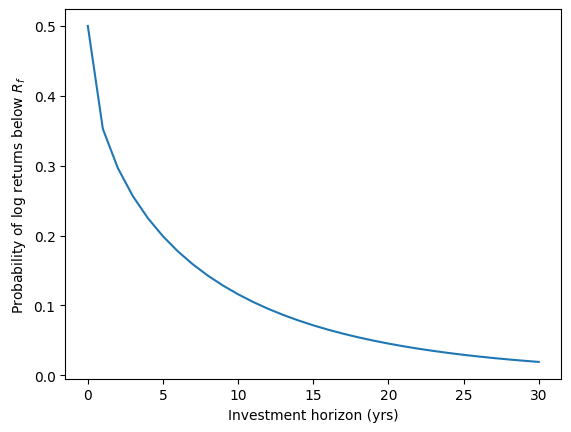

In [6]:
# 2.3

probs = [compute_prob_log_returns_below_rf(t, SR.iloc[4]) for t in range(31)]

plt.plot(range(31), probs)
plt.xlabel("Investment horizon (yrs)")
plt.ylabel("Probability of log returns below $R_f$")
plt.show()

### 3. Full Sample Analysis

Use the sample 1965-{END_YR} to reconsider the 30-year probability. As of the end of {END_YR}, calculate the probability of the stock return underperforming the risk-free rate over the next 30 years. That is, $R^m_{t,t+h}$ underperforming $R^f_{t,t+h}$ for $0<h\le 30$.

In [7]:
# 3 - full sample analysis
SR = compute_sharpe_for_period(raw_df, start_year=1965, end_year=END_YR)
thirty_year_prob = compute_prob_log_returns_below_rf(30, SR.iloc[4])
print(thirty_year_prob)

0.019248146171370977


### 4. In-Sample Estimate of Out-of-Sample Likelihood

Let's consider how things turned out relative to Barnstable's 1999 expectations.

What was the probability (based on the 1999 estimate of $\mu$) that the `h`-year market return, $R^m_{t,t+h}$, would be smaller than that realized in `2000-{END_YR}`? 

**Hint**: You can calculate this as:

$$p = \Phi_{\mathcal{N}}\left(\sqrt{h}\; \frac{\bar{\texttt{r}}_{out-of-sample} - \bar{\texttt{r}}_{\text{in-sample}}}{\sigma_{\text{in-sample}}}\right)$$

where "in-sample" denotes 1965-1999 and "out-of-sample" denotes 2000-{END_YR}.

In [8]:
# 4 - in-sample estimate of OOS likelihood
is_key = "1965-1999"
oos_key = f"2000-{END_YR}"
r_out_of_sample = sum_stats[oos_key]['mean'].iloc[4]
r_in_sample = sum_stats[is_key]['mean'].iloc[4]
vol_in_sample = sum_stats[is_key]['vol'].iloc[4]
print_float(compute_prob_log_returns_below_rf(END_YR - 2000, (r_out_of_sample-r_in_sample)/vol_in_sample))

0.4873


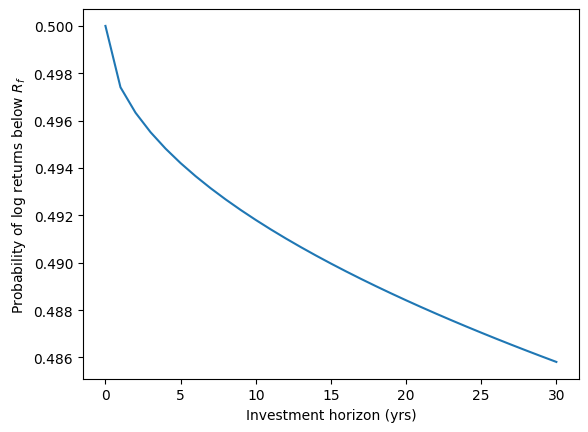

In [9]:
probs = [compute_prob_log_returns_below_rf(t, (r_out_of_sample-r_in_sample)/vol_in_sample) for t in range(31)]

plt.plot(range(31), probs)
plt.xlabel("Investment horizon (yrs)")
plt.ylabel("Probability of log returns below $R_f$")
plt.show()